In [1]:
pip install xgboost lightgbm catboost optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 5.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.3 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 7.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 10.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 kB 4.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 22.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna 

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/PS-S3/Ep7/train.csv'
file_key_2 = 'Tabular-Playground-Series/PS-S3/Ep7/test.csv'
file_key_3 = 'Tabular-Playground-Series/PS-S3/Ep7/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

## Fixing dates (https://www.kaggle.com/competitions/playground-series-s3e7/discussion/386655)
train['arrival_year_month'] = pd.to_datetime(train['arrival_year'].astype(str) + train['arrival_month'].astype(str), format = '%Y%m')
test['arrival_year_month'] = pd.to_datetime(test['arrival_year'].astype(str) + test['arrival_month'].astype(str), format = '%Y%m')

train.loc[train.arrival_date > train.arrival_year_month.dt.days_in_month, 'arrival_date'] = train.arrival_year_month.dt.days_in_month
test.loc[test.arrival_date > test.arrival_year_month.dt.days_in_month, 'arrival_date'] = test.arrival_year_month.dt.days_in_month

train.drop(columns = 'arrival_year_month', inplace = True)
test.drop(columns = 'arrival_year_month', inplace = True)

train['low_price_flag'] = np.where(train['avg_price_per_room'] < 30, 1, 0)
train['segment_0'] = np.where(train['market_segment_type'] == 0, 1, 0)
train['segment_1'] = np.where(train['market_segment_type'] == 1, 1, 0)
train['total_guests'] = train['no_of_adults'] + train['no_of_children']
train['stay_length'] = train['no_of_weekend_nights'] + train['no_of_week_nights']
train['stay_during_weekend'] = np.where(train['no_of_weekend_nights'] > 0, 1, 0)
train['quarter_1'] = np.where(train['arrival_month'] <= 3, 1, 0)
train['quarter_2'] = np.where(((train['arrival_month'] >= 4) & (train['arrival_month'] <= 6)), 1, 0)
train['quarter_3'] = np.where(((train['arrival_month'] >= 7) & (train['arrival_month'] <= 9)), 1, 0)
train['quarter_4'] = np.where(train['arrival_month'] >= 10, 1, 0)
train['segment_0_feature_1'] = np.where(((train['market_segment_type'] == 0) & (train['lead_time'] <= 90)), 1, 0)
train['segment_0_feature_2'] = np.where(((train['market_segment_type'] == 0) & (train['avg_price_per_room'] > 98)), 1, 0)
train['segment_1_feature_1'] = np.where(((train['market_segment_type'] == 1) & (train['no_of_special_requests'] == 0)), 1, 0)
train['segment_1_feature_2'] = np.where(((train['market_segment_type'] == 1) & (train['no_of_special_requests'] > 0) & (train['lead_time'] <= 150)), 1, 0)
train['segment_0_year_flag'] = np.where(((train['market_segment_type'] == 0) & (train['arrival_year'] == 2018)), 1, 0)
train['segment_1_year_flag'] = np.where(((train['market_segment_type'] == 1) & (train['arrival_year'] == 2018)), 1, 0)
train['price_lead_time_flag'] = np.where(((train['avg_price_per_room'] > 100) & (train['lead_time'] > 150)), 1, 0)

test['low_price_flag'] = np.where(test['avg_price_per_room'] < 30, 1, 0)
test['segment_0'] = np.where(test['market_segment_type'] == 0, 1, 0)
test['segment_1'] = np.where(test['market_segment_type'] == 1, 1, 0)
test['total_guests'] = test['no_of_adults'] + test['no_of_children']
test['stay_length'] = test['no_of_weekend_nights'] + test['no_of_week_nights']
test['stay_during_weekend'] = np.where(test['no_of_weekend_nights'] > 0, 1, 0)
test['quarter_1'] = np.where(test['arrival_month'] <= 3, 1, 0)
test['quarter_2'] = np.where(((test['arrival_month'] >= 4) & (test['arrival_month'] <= 6)), 1, 0)
test['quarter_3'] = np.where(((test['arrival_month'] >= 7) & (test['arrival_month'] <= 9)), 1, 0)
test['quarter_4'] = np.where(test['arrival_month'] >= 10, 1, 0)
test['segment_0_feature_1'] = np.where(((test['market_segment_type'] == 0) & (test['lead_time'] <= 90)), 1, 0)
test['segment_0_feature_2'] = np.where(((test['market_segment_type'] == 0) & (test['avg_price_per_room'] > 98)), 1, 0)
test['segment_1_feature_1'] = np.where(((test['market_segment_type'] == 1) & (test['no_of_special_requests'] == 0)), 1, 0)
test['segment_1_feature_2'] = np.where(((test['market_segment_type'] == 1) & (test['no_of_special_requests'] > 0) & (test['lead_time'] <= 150)), 1, 0)
test['segment_0_year_flag'] = np.where(((test['market_segment_type'] == 0) & (test['arrival_year'] == 2018)), 1, 0)
test['segment_1_year_flag'] = np.where(((test['market_segment_type'] == 1) & (test['arrival_year'] == 2018)), 1, 0)
test['price_lead_time_flag'] = np.where(((test['avg_price_per_room'] > 100) & (test['lead_time'] > 150)), 1, 0)

In [3]:
train.head()

,id,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,low_price_flag,segment_0,segment_1,total_guests,stay_length,stay_during_weekend,quarter_1,quarter_2,quarter_3,quarter_4,segment_0_feature_1,segment_0_feature_2,segment_1_feature_1,segment_1_feature_2,segment_0_year_flag,segment_1_year_flag,price_lead_time_flag
0,0,2,0,0,2,1,0,0,9,2018,1,14,1,1,11,0,67.50,0,0,0,0,1,2,2,0,1,0,0,0,0,0,1,0,0,1,0
1,1,2,0,1,2,0,0,0,117,2018,7,29,0,0,0,0,72.25,0,0,0,1,0,2,3,1,0,0,1,0,0,0,0,0,1,0,0
2,2,2,0,0,1,0,0,0,315,2018,12,2,0,0,0,0,52.00,0,0,0,1,0,2,1,0,0,0,0,1,0,0,0,0,1,0,0
3,3,1,0,0,2,1,0,0,32,2018,12,1,1,0,0,0,56.00,0,0,0,0,1,1,2,0,0,0,0,1,0,0,1,0,0,1,0
4,4,2,0,1,0,0,0,0,258,2018,10,16,0,0,0,0,100.00,0,1,0,1,0,2,1,1,0,0,0,1,0,1,0,0,1,0,0


In [3]:
from sklearn.kernel_approximation import RBFSampler

X = train[['avg_price_per_room', 'lead_time']]

rbf_feature = RBFSampler(gamma = 1, random_state = 1)
A_features = rbf_feature.fit_transform(A)

In [4]:
A_features[:, 0:3]

array([[-0.09208778, -0.14120205, -0.13776265],
       [-0.14135896, -0.10259444, -0.0374632 ],
       [ 0.0645009 ,  0.14031746,  0.11619809],
       ...,
       [-0.12560176, -0.12282998,  0.02386545],
       [ 0.01417382,  0.06221048,  0.08961509],
       [-0.11265978, -0.11284745, -0.12549384]])

In [4]:
train.columns

Index(['id', 'no_of_adults', 'no_of_children', 'no_of_weekend_nights',
       'no_of_week_nights', 'type_of_meal_plan', 'required_car_parking_space',
       'room_type_reserved', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_date', 'market_segment_type', 'repeated_guest',
       'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
       'avg_price_per_room', 'no_of_special_requests', 'booking_status',
       'low_price_flag', 'segment_0', 'segment_1', 'total_guests',
       'stay_length', 'stay_during_weekend', 'quarter_1', 'quarter_2',
       'quarter_3', 'quarter_4', 'segment_0_feature_1', 'segment_0_feature_2',
       'segment_1_feature_1', 'segment_1_feature_2', 'segment_0_year_flag',
       'segment_1_year_flag', 'price_lead_time_flag'],
      dtype='object')

In [17]:
train_lgb = train.copy()
test_lgb = test.copy()

# X = train_lgb[['avg_price_per_room', 'lead_time', 'segment_0', 'segment_1', 'total_guests', 'stay_length', 'stay_during_weekend', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'segment_0_feature_1', 'segment_0_feature_2', 'segment_1_feature_1', 'segment_1_feature_2', 'segment_0_year_flag', 'segment_1_year_flag']]
# Y = train_lgb['booking_status']

# test_lgb = test_lgb[['avg_price_per_room', 'lead_time', 'segment_0', 'segment_1', 'total_guests', 'stay_length', 'stay_during_weekend', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'segment_0_feature_1', 'segment_0_feature_2', 'segment_1_feature_1', 'segment_1_feature_2', 'segment_0_year_flag', 'segment_1_year_flag']]

# X = train_lgb[['avg_price_per_room', 'lead_time', 'total_guests', 'stay_length', 'segment_0_feature_1', 'segment_1_feature_1']]
X = train_lgb[['avg_price_per_room', 'lead_time', 'total_guests', 'stay_length', 'arrival_year', 'arrival_month', 'arrival_date', 'market_segment_type', 'repeated_guest', 'no_of_special_requests']]
Y = train_lgb['booking_status']

test_lgb = test_lgb[['avg_price_per_room', 'lead_time', 'total_guests', 'stay_length', 'arrival_year', 'arrival_month', 'arrival_date', 'market_segment_type', 'repeated_guest', 'no_of_special_requests']]

# Optuna Optimization

In [18]:
class Objective:

    def __init__(self, seed):
        # Hold this implementation specific arguments as the fields of the class.
        self.seed = seed

    def __call__(self, trial):
        ## Parameters to be evaluated
        param = dict(objective = 'binary',
                     metric = 'auc',
                     tree_method = 'gbdt', 
                     n_estimators = trial.suggest_int('n_estimators', 300, 10000),
                     learning_rate = trial.suggest_float('learning_rate', 0.001, 1, log = True),
                     max_depth = trial.suggest_int('max_depth', 3, 12),
                     lambda_l1 = trial.suggest_float('lambda_l1', 0.01, 10.0, log = True),
                     lambda_l2 = trial.suggest_float('lambda_l2', 0.01, 10.0, log = True),
                     num_leaves = trial.suggest_int('num_leaves', 2, 100),
                     bagging_fraction = trial.suggest_float('bagging_fraction', 0.2, 0.9),
                     feature_fraction = trial.suggest_float('feature_fraction', 0.2, 0.9)
                    )

        scores = []
        
        skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = self.seed)
#         skf = KFold(n_splits = 5, shuffle = True, random_state = self.seed)

        for train_idx, valid_idx in skf.split(X, Y):

            X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
            Y_train , Y_valid = Y.iloc[train_idx] , Y.iloc[valid_idx]

            model = LGBMClassifier(**param).fit(X_train, Y_train)

#             preds_train = model.predict(X_train)
            preds_valid = model.predict_proba(X_valid)[:, 1]

            score = roc_auc_score(Y_valid, preds_valid)
            scores.append(score)

        return np.mean(scores)
    
## Defining number of runs and seed
RUNS = 2
SEED = 42
N_TRIALS = 50

# Execute an optimization
study = optuna.create_study(direction = 'maximize')
study.optimize(Objective(SEED), n_trials = N_TRIALS)

[I 2023-02-18 23:56:32,222] A new study created in memory with name: no-name-1c7a21cb-f418-4d23-97a3-fa09379aeec8


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.13101262105094413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13101262105094413
[LightGBM] [Warning] feature_fraction is set=0.8043317989945271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8043317989945271
[LightGBM] [Warning] lambda_l2 is set=5.5746929359074135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.5746929359074135
[LightGBM] [Warning] bagging_fraction is set=0.4875685403706171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4875685403706171
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.13101262105094413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13101262105094413
[LightGBM] [Warning] feature_fraction is set=0.8043317989945271, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8043317989945271
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-18 23:56:37,643] Trial 0 finished with value: 0.8862968754786525 and parameters: {'n_estimators': 920, 'learning_rate': 0.018268683544412835, 'max_depth': 5, 'lambda_l1': 0.13101262105094413, 'lambda_l2': 5.5746929359074135, 'num_leaves': 9, 'bagging_fraction': 0.4875685403706171, 'feature_fraction': 0.8043317989945271}. Best is trial 0 with value: 0.8862968754786525.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.15878675233938594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15878675233938594
[LightGBM] [Warning] feature_fraction is set=0.75586351951346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75586351951346
[LightGBM] [Warning] lambda_l2 is set=0.19214688324149276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19214688324149276
[LightGBM] [Warning] bagging_fraction is set=0.6218777107231552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6218777107231552
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.15878675233938594, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15878675233938594
[LightGBM] [Warning] feature_fraction is set=0.75586351951346, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75586351951346
[LightGBM] [Warning] lambda_l2 is set=0.192

[I 2023-02-18 23:56:59,354] Trial 1 finished with value: 0.8646091082098998 and parameters: {'n_estimators': 1593, 'learning_rate': 0.31351603648109866, 'max_depth': 9, 'lambda_l1': 0.15878675233938594, 'lambda_l2': 0.19214688324149276, 'num_leaves': 69, 'bagging_fraction': 0.6218777107231552, 'feature_fraction': 0.75586351951346}. Best is trial 0 with value: 0.8862968754786525.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.3947548772937581, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3947548772937581
[LightGBM] [Warning] feature_fraction is set=0.7937771701758645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7937771701758645
[LightGBM] [Warning] lambda_l2 is set=0.016875421704920148, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.016875421704920148
[LightGBM] [Warning] bagging_fraction is set=0.5752306527721063, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5752306527721063
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=1.3947548772937581, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3947548772937581
[LightGBM] [Warning] feature_fraction is set=0.7937771701758645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7937771701758645
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-18 23:57:53,491] Trial 2 finished with value: 0.8917021455305145 and parameters: {'n_estimators': 6761, 'learning_rate': 0.012768208363370103, 'max_depth': 10, 'lambda_l1': 1.3947548772937581, 'lambda_l2': 0.016875421704920148, 'num_leaves': 41, 'bagging_fraction': 0.5752306527721063, 'feature_fraction': 0.7937771701758645}. Best is trial 2 with value: 0.8917021455305145.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.09073912921101843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09073912921101843
[LightGBM] [Warning] feature_fraction is set=0.27992307291513296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27992307291513296
[LightGBM] [Warning] lambda_l2 is set=0.021460992334825034, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021460992334825034
[LightGBM] [Warning] bagging_fraction is set=0.6681127455959315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6681127455959315
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.09073912921101843, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09073912921101843
[LightGBM] [Warning] feature_fraction is set=0.27992307291513296, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.27992307291513296
[LightGBM] [Warning] lambda_l

[I 2023-02-18 23:58:51,490] Trial 3 finished with value: 0.8942786185477513 and parameters: {'n_estimators': 9251, 'learning_rate': 0.00448608710219226, 'max_depth': 5, 'lambda_l1': 0.09073912921101843, 'lambda_l2': 0.021460992334825034, 'num_leaves': 87, 'bagging_fraction': 0.6681127455959315, 'feature_fraction': 0.27992307291513296}. Best is trial 3 with value: 0.8942786185477513.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.34388931844772447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34388931844772447
[LightGBM] [Warning] feature_fraction is set=0.4363718715251067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4363718715251067
[LightGBM] [Warning] lambda_l2 is set=2.844943784310149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.844943784310149
[LightGBM] [Warning] bagging_fraction is set=0.5293722659411306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5293722659411306
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.34388931844772447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34388931844772447
[LightGBM] [Warning] feature_fraction is set=0.4363718715251067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4363718715251067
[LightGBM] [Warning] lambda_l2 is set=2

[I 2023-02-18 23:59:08,656] Trial 4 finished with value: 0.8844034583762612 and parameters: {'n_estimators': 3886, 'learning_rate': 0.005832003420380223, 'max_depth': 3, 'lambda_l1': 0.34388931844772447, 'lambda_l2': 2.844943784310149, 'num_leaves': 47, 'bagging_fraction': 0.5293722659411306, 'feature_fraction': 0.4363718715251067}. Best is trial 3 with value: 0.8942786185477513.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.061265525470958135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.061265525470958135
[LightGBM] [Warning] feature_fraction is set=0.5711183591822653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5711183591822653
[LightGBM] [Warning] lambda_l2 is set=0.011746116006307981, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011746116006307981
[LightGBM] [Warning] bagging_fraction is set=0.8291393639467057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8291393639467057
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.061265525470958135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.061265525470958135
[LightGBM] [Warning] feature_fraction is set=0.5711183591822653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5711183591822653
[LightGBM] [Warning] lambda_l

[I 2023-02-18 23:59:19,239] Trial 5 finished with value: 0.8948057993995718 and parameters: {'n_estimators': 1819, 'learning_rate': 0.022943135121538626, 'max_depth': 11, 'lambda_l1': 0.061265525470958135, 'lambda_l2': 0.011746116006307981, 'num_leaves': 17, 'bagging_fraction': 0.8291393639467057, 'feature_fraction': 0.5711183591822653}. Best is trial 5 with value: 0.8948057993995718.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=4.053649851064026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.053649851064026
[LightGBM] [Warning] feature_fraction is set=0.6930961670227015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6930961670227015
[LightGBM] [Warning] lambda_l2 is set=0.2787622886703698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2787622886703698
[LightGBM] [Warning] bagging_fraction is set=0.6355849252451451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6355849252451451
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=4.053649851064026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.053649851064026
[LightGBM] [Warning] feature_fraction is set=0.6930961670227015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6930961670227015
[LightGBM] [Warning] lambda_l2 is set=0.27876

[I 2023-02-18 23:59:40,261] Trial 6 finished with value: 0.8914498571886877 and parameters: {'n_estimators': 7868, 'learning_rate': 0.20334306937404495, 'max_depth': 8, 'lambda_l1': 4.053649851064026, 'lambda_l2': 0.2787622886703698, 'num_leaves': 80, 'bagging_fraction': 0.6355849252451451, 'feature_fraction': 0.6930961670227015}. Best is trial 5 with value: 0.8948057993995718.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.3050871564020891, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3050871564020891
[LightGBM] [Warning] feature_fraction is set=0.26204739552435075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26204739552435075
[LightGBM] [Warning] lambda_l2 is set=0.14312941941419743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14312941941419743
[LightGBM] [Warning] bagging_fraction is set=0.31191794551788415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.31191794551788415
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.3050871564020891, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3050871564020891
[LightGBM] [Warning] feature_fraction is set=0.26204739552435075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.26204739552435075
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-19 00:00:39,319] Trial 7 finished with value: 0.8561475064827118 and parameters: {'n_estimators': 9606, 'learning_rate': 0.8449775006532761, 'max_depth': 4, 'lambda_l1': 0.3050871564020891, 'lambda_l2': 0.14312941941419743, 'num_leaves': 80, 'bagging_fraction': 0.31191794551788415, 'feature_fraction': 0.26204739552435075}. Best is trial 5 with value: 0.8948057993995718.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.014595115110480962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014595115110480962
[LightGBM] [Warning] feature_fraction is set=0.20963785092891618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20963785092891618
[LightGBM] [Warning] lambda_l2 is set=0.030653841405247493, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.030653841405247493
[LightGBM] [Warning] bagging_fraction is set=0.8311720855032521, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8311720855032521
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.014595115110480962, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014595115110480962
[LightGBM] [Warning] feature_fraction is set=0.20963785092891618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20963785092891618
[LightGBM] [Warning] lamb

[I 2023-02-19 00:01:23,237] Trial 8 finished with value: 0.8913236287138913 and parameters: {'n_estimators': 4782, 'learning_rate': 0.017880788163917465, 'max_depth': 12, 'lambda_l1': 0.014595115110480962, 'lambda_l2': 0.030653841405247493, 'num_leaves': 64, 'bagging_fraction': 0.8311720855032521, 'feature_fraction': 0.20963785092891618}. Best is trial 5 with value: 0.8948057993995718.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.036086673227131744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036086673227131744
[LightGBM] [Warning] feature_fraction is set=0.45233787617181936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45233787617181936
[LightGBM] [Warning] lambda_l2 is set=5.44632556415682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.44632556415682
[LightGBM] [Warning] bagging_fraction is set=0.2527396281648205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2527396281648205
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.036086673227131744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036086673227131744
[LightGBM] [Warning] feature_fraction is set=0.45233787617181936, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45233787617181936
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-19 00:01:55,632] Trial 9 finished with value: 0.8727767016909457 and parameters: {'n_estimators': 7451, 'learning_rate': 0.0011387559293284928, 'max_depth': 3, 'lambda_l1': 0.036086673227131744, 'lambda_l2': 5.44632556415682, 'num_leaves': 5, 'bagging_fraction': 0.2527396281648205, 'feature_fraction': 0.45233787617181936}. Best is trial 5 with value: 0.8948057993995718.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.0122963893455378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0122963893455378
[LightGBM] [Warning] feature_fraction is set=0.6326644730658011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6326644730658011
[LightGBM] [Warning] lambda_l2 is set=0.010134020348430786, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010134020348430786
[LightGBM] [Warning] bagging_fraction is set=0.8825572789639424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8825572789639424
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.0122963893455378, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0122963893455378
[LightGBM] [Warning] feature_fraction is set=0.6326644730658011, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6326644730658011
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-19 00:02:15,348] Trial 10 finished with value: 0.8879874602043814 and parameters: {'n_estimators': 2695, 'learning_rate': 0.06707678338832332, 'max_depth': 12, 'lambda_l1': 0.0122963893455378, 'lambda_l2': 0.010134020348430786, 'num_leaves': 28, 'bagging_fraction': 0.8825572789639424, 'feature_fraction': 0.6326644730658011}. Best is trial 5 with value: 0.8948057993995718.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.062403221350550264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.062403221350550264
[LightGBM] [Warning] feature_fraction is set=0.5485081012276491, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5485081012276491
[LightGBM] [Warning] lambda_l2 is set=0.046726780891018116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046726780891018116
[LightGBM] [Warning] bagging_fraction is set=0.7639220944195012, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7639220944195012
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.062403221350550264, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.062403221350550264
[LightGBM] [Warning] feature_fraction is set=0.5485081012276491, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5485081012276491
[LightGBM] [Warning] lambda_l

[I 2023-02-19 00:03:44,247] Trial 11 finished with value: 0.8955264787918429 and parameters: {'n_estimators': 9604, 'learning_rate': 0.0037639591430529817, 'max_depth': 6, 'lambda_l1': 0.062403221350550264, 'lambda_l2': 0.046726780891018116, 'num_leaves': 99, 'bagging_fraction': 0.7639220944195012, 'feature_fraction': 0.5485081012276491}. Best is trial 11 with value: 0.8955264787918429.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.04298357624750298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04298357624750298
[LightGBM] [Warning] feature_fraction is set=0.5686203995744086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5686203995744086
[LightGBM] [Warning] lambda_l2 is set=0.06087500778880799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06087500778880799
[LightGBM] [Warning] bagging_fraction is set=0.7819606079462222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7819606079462222
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.04298357624750298, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04298357624750298
[LightGBM] [Warning] feature_fraction is set=0.5686203995744086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5686203995744086
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-19 00:04:21,550] Trial 12 finished with value: 0.88155052868449 and parameters: {'n_estimators': 5971, 'learning_rate': 0.059857508450344175, 'max_depth': 7, 'lambda_l1': 0.04298357624750298, 'lambda_l2': 0.06087500778880799, 'num_leaves': 26, 'bagging_fraction': 0.7819606079462222, 'feature_fraction': 0.5686203995744086}. Best is trial 11 with value: 0.8955264787918429.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.03521418906859995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03521418906859995
[LightGBM] [Warning] feature_fraction is set=0.8832089218127519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8832089218127519
[LightGBM] [Warning] lambda_l2 is set=0.060285139888054944, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.060285139888054944
[LightGBM] [Warning] bagging_fraction is set=0.7600941009878714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7600941009878714
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.03521418906859995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03521418906859995
[LightGBM] [Warning] feature_fraction is set=0.8832089218127519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8832089218127519
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-19 00:05:04,655] Trial 13 finished with value: 0.8887827734665636 and parameters: {'n_estimators': 3297, 'learning_rate': 0.0017670535509615084, 'max_depth': 7, 'lambda_l1': 0.03521418906859995, 'lambda_l2': 0.060285139888054944, 'num_leaves': 99, 'bagging_fraction': 0.7600941009878714, 'feature_fraction': 0.8832089218127519}. Best is trial 11 with value: 0.8955264787918429.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.06685197884355189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06685197884355189
[LightGBM] [Warning] feature_fraction is set=0.5560724924460367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5560724924460367
[LightGBM] [Warning] lambda_l2 is set=0.03690217896674611, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03690217896674611
[LightGBM] [Warning] bagging_fraction is set=0.8871426650427977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8871426650427977
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.06685197884355189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06685197884355189
[LightGBM] [Warning] feature_fraction is set=0.5560724924460367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5560724924460367
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-19 00:05:19,453] Trial 14 finished with value: 0.8876126353455887 and parameters: {'n_estimators': 2082, 'learning_rate': 0.0036946855674227083, 'max_depth': 6, 'lambda_l1': 0.06685197884355189, 'lambda_l2': 0.03690217896674611, 'num_leaves': 22, 'bagging_fraction': 0.8871426650427977, 'feature_fraction': 0.5560724924460367}. Best is trial 11 with value: 0.8955264787918429.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.37052448709185526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37052448709185526
[LightGBM] [Warning] feature_fraction is set=0.47580281335167307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47580281335167307
[LightGBM] [Warning] lambda_l2 is set=0.015057591451803852, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015057591451803852
[LightGBM] [Warning] bagging_fraction is set=0.7429017400625068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7429017400625068
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.37052448709185526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.37052448709185526
[LightGBM] [Warning] feature_fraction is set=0.47580281335167307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47580281335167307
[LightGBM] [Warning] lambda_l

[I 2023-02-19 00:06:17,223] Trial 15 finished with value: 0.8944792801205166 and parameters: {'n_estimators': 4861, 'learning_rate': 0.008656937393219395, 'max_depth': 11, 'lambda_l1': 0.37052448709185526, 'lambda_l2': 0.015057591451803852, 'num_leaves': 60, 'bagging_fraction': 0.7429017400625068, 'feature_fraction': 0.47580281335167307}. Best is trial 11 with value: 0.8955264787918429.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.022986426949017733, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022986426949017733
[LightGBM] [Warning] feature_fraction is set=0.6433088356829604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6433088356829604
[LightGBM] [Warning] lambda_l2 is set=0.07441110632566617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07441110632566617
[LightGBM] [Warning] bagging_fraction is set=0.7070475414474129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7070475414474129
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.022986426949017733, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022986426949017733
[LightGBM] [Warning] feature_fraction is set=0.6433088356829604, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6433088356829604
[LightGBM] [Warning] lambda_l2 

[I 2023-02-19 00:08:29,024] Trial 16 finished with value: 0.8684241831076391 and parameters: {'n_estimators': 8567, 'learning_rate': 0.034307095472538456, 'max_depth': 9, 'lambda_l1': 0.022986426949017733, 'lambda_l2': 0.07441110632566617, 'num_leaves': 100, 'bagging_fraction': 0.7070475414474129, 'feature_fraction': 0.6433088356829604}. Best is trial 11 with value: 0.8955264787918429.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.010500459667159604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010500459667159604
[LightGBM] [Warning] feature_fraction is set=0.38758858292756665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38758858292756665
[LightGBM] [Warning] lambda_l2 is set=0.010525813967966724, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010525813967966724
[LightGBM] [Warning] bagging_fraction is set=0.798560208515017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.798560208515017
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.010500459667159604, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010500459667159604
[LightGBM] [Warning] feature_fraction is set=0.38758858292756665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.38758858292756665
[LightGBM] [Warning] lambda

[I 2023-02-19 00:09:33,988] Trial 17 finished with value: 0.8935110189029523 and parameters: {'n_estimators': 6536, 'learning_rate': 0.0022926675564305106, 'max_depth': 10, 'lambda_l1': 0.010500459667159604, 'lambda_l2': 0.010525813967966724, 'num_leaves': 40, 'bagging_fraction': 0.798560208515017, 'feature_fraction': 0.38758858292756665}. Best is trial 11 with value: 0.8955264787918429.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.06233411030844509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06233411030844509
[LightGBM] [Warning] feature_fraction is set=0.5219643129213565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5219643129213565
[LightGBM] [Warning] lambda_l2 is set=0.5709406314941174, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5709406314941174
[LightGBM] [Warning] bagging_fraction is set=0.8335653709379663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8335653709379663
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.06233411030844509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06233411030844509
[LightGBM] [Warning] feature_fraction is set=0.5219643129213565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5219643129213565
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-19 00:10:06,813] Trial 18 finished with value: 0.895434789968785 and parameters: {'n_estimators': 3935, 'learning_rate': 0.007311181455960592, 'max_depth': 6, 'lambda_l1': 0.06233411030844509, 'lambda_l2': 0.5709406314941174, 'num_leaves': 54, 'bagging_fraction': 0.8335653709379663, 'feature_fraction': 0.5219643129213565}. Best is trial 11 with value: 0.8955264787918429.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.020655465216038192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020655465216038192
[LightGBM] [Warning] feature_fraction is set=0.4847453910862621, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4847453910862621
[LightGBM] [Warning] lambda_l2 is set=0.5857529921820962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5857529921820962
[LightGBM] [Warning] bagging_fraction is set=0.705512967926524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.705512967926524
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.020655465216038192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.020655465216038192
[LightGBM] [Warning] feature_fraction is set=0.4847453910862621, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4847453910862621
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-19 00:10:44,233] Trial 19 finished with value: 0.8856824069523794 and parameters: {'n_estimators': 3952, 'learning_rate': 0.0010396161655053624, 'max_depth': 6, 'lambda_l1': 0.020655465216038192, 'lambda_l2': 0.5857529921820962, 'num_leaves': 55, 'bagging_fraction': 0.705512967926524, 'feature_fraction': 0.4847453910862621}. Best is trial 11 with value: 0.8955264787918429.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.14422170052321193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14422170052321193
[LightGBM] [Warning] feature_fraction is set=0.3681369745579531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3681369745579531
[LightGBM] [Warning] lambda_l2 is set=0.7106543538205837, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7106543538205837
[LightGBM] [Warning] bagging_fraction is set=0.88034338030057, subsample=1.0 will be ignored. Current value: bagging_fraction=0.88034338030057
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.14422170052321193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14422170052321193
[LightGBM] [Warning] feature_fraction is set=0.3681369745579531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3681369745579531
[LightGBM] [Warning] lambda_l2 is set=0.7

[I 2023-02-19 00:11:19,499] Trial 20 finished with value: 0.8942666638487777 and parameters: {'n_estimators': 5592, 'learning_rate': 0.007649249151663678, 'max_depth': 5, 'lambda_l1': 0.14422170052321193, 'lambda_l2': 0.7106543538205837, 'num_leaves': 73, 'bagging_fraction': 0.88034338030057, 'feature_fraction': 0.3681369745579531}. Best is trial 11 with value: 0.8955264787918429.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.06259680193945132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06259680193945132
[LightGBM] [Warning] feature_fraction is set=0.5386293195118687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5386293195118687
[LightGBM] [Warning] lambda_l2 is set=0.03181519645785625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03181519645785625
[LightGBM] [Warning] bagging_fraction is set=0.8252461064956493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8252461064956493
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.06259680193945132, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06259680193945132
[LightGBM] [Warning] feature_fraction is set=0.5386293195118687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5386293195118687
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-19 00:11:23,057] Trial 21 finished with value: 0.870439178917595 and parameters: {'n_estimators': 539, 'learning_rate': 0.003090923998267086, 'max_depth': 8, 'lambda_l1': 0.06259680193945132, 'lambda_l2': 0.03181519645785625, 'num_leaves': 13, 'bagging_fraction': 0.8252461064956493, 'feature_fraction': 0.5386293195118687}. Best is trial 11 with value: 0.8955264787918429.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.03366920671628708, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03366920671628708
[LightGBM] [Warning] feature_fraction is set=0.593158954351847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.593158954351847
[LightGBM] [Warning] lambda_l2 is set=0.11464690572297384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11464690572297384
[LightGBM] [Warning] bagging_fraction is set=0.8232633426469658, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8232633426469658
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.03366920671628708, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03366920671628708
[LightGBM] [Warning] feature_fraction is set=0.593158954351847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.593158954351847
[LightGBM] [Warning] lambda_l2 is set=0

[I 2023-02-19 00:11:43,603] Trial 22 finished with value: 0.8948375228134585 and parameters: {'n_estimators': 2668, 'learning_rate': 0.009569458996783978, 'max_depth': 6, 'lambda_l1': 0.03366920671628708, 'lambda_l2': 0.11464690572297384, 'num_leaves': 37, 'bagging_fraction': 0.8232633426469658, 'feature_fraction': 0.593158954351847}. Best is trial 11 with value: 0.8955264787918429.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.025633343613510065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025633343613510065
[LightGBM] [Warning] feature_fraction is set=0.6082729382130176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6082729382130176
[LightGBM] [Warning] lambda_l2 is set=0.11036146063304829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11036146063304829
[LightGBM] [Warning] bagging_fraction is set=0.7363691966453887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7363691966453887
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.025633343613510065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.025633343613510065
[LightGBM] [Warning] feature_fraction is set=0.6082729382130176, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6082729382130176
[LightGBM] [Warning] lambda_l2 

[I 2023-02-19 00:12:12,213] Trial 23 finished with value: 0.8947517817602659 and parameters: {'n_estimators': 3036, 'learning_rate': 0.008349560669921147, 'max_depth': 6, 'lambda_l1': 0.025633343613510065, 'lambda_l2': 0.11036146063304829, 'num_leaves': 36, 'bagging_fraction': 0.7363691966453887, 'feature_fraction': 0.6082729382130176}. Best is trial 11 with value: 0.8955264787918429.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.04332438868780259, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04332438868780259
[LightGBM] [Warning] feature_fraction is set=0.5095853536458335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5095853536458335
[LightGBM] [Warning] lambda_l2 is set=0.41192065475397927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41192065475397927
[LightGBM] [Warning] bagging_fraction is set=0.7825785044311117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7825785044311117
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.04332438868780259, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04332438868780259
[LightGBM] [Warning] feature_fraction is set=0.5095853536458335, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5095853536458335
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-19 00:12:34,687] Trial 24 finished with value: 0.8887263549795682 and parameters: {'n_estimators': 4128, 'learning_rate': 0.00454244248098509, 'max_depth': 4, 'lambda_l1': 0.04332438868780259, 'lambda_l2': 0.41192065475397927, 'num_leaves': 50, 'bagging_fraction': 0.7825785044311117, 'feature_fraction': 0.5095853536458335}. Best is trial 11 with value: 0.8955264787918429.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.018204871642643543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018204871642643543
[LightGBM] [Warning] feature_fraction is set=0.6926040325834113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6926040325834113
[LightGBM] [Warning] lambda_l2 is set=0.22199973500761364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22199973500761364
[LightGBM] [Warning] bagging_fraction is set=0.8973451250886719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8973451250886719
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.018204871642643543, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018204871642643543
[LightGBM] [Warning] feature_fraction is set=0.6926040325834113, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6926040325834113
[LightGBM] [Warning] lambda_l2 

[I 2023-02-19 00:12:54,357] Trial 25 finished with value: 0.8877442063182077 and parameters: {'n_estimators': 2362, 'learning_rate': 0.002291429642111123, 'max_depth': 7, 'lambda_l1': 0.018204871642643543, 'lambda_l2': 0.22199973500761364, 'num_leaves': 32, 'bagging_fraction': 0.8973451250886719, 'feature_fraction': 0.6926040325834113}. Best is trial 11 with value: 0.8955264787918429.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.0908703615168392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0908703615168392
[LightGBM] [Warning] feature_fraction is set=0.5252720921360519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5252720921360519
[LightGBM] [Warning] lambda_l2 is set=0.10424787910442299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10424787910442299
[LightGBM] [Warning] bagging_fraction is set=0.8280403317002677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8280403317002677
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.0908703615168392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0908703615168392
[LightGBM] [Warning] feature_fraction is set=0.5252720921360519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5252720921360519
[LightGBM] [Warning] lambda_l2 is set=0

[I 2023-02-19 00:13:21,567] Trial 26 finished with value: 0.8955297392831376 and parameters: {'n_estimators': 3412, 'learning_rate': 0.011227740160609364, 'max_depth': 6, 'lambda_l1': 0.0908703615168392, 'lambda_l2': 0.10424787910442299, 'num_leaves': 90, 'bagging_fraction': 0.8280403317002677, 'feature_fraction': 0.5252720921360519}. Best is trial 26 with value: 0.8955297392831376.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.07898671879627044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07898671879627044
[LightGBM] [Warning] feature_fraction is set=0.518161565008762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.518161565008762
[LightGBM] [Warning] lambda_l2 is set=1.0393884234788489, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0393884234788489
[LightGBM] [Warning] bagging_fraction is set=0.7160393347825058, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7160393347825058
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.07898671879627044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07898671879627044
[LightGBM] [Warning] feature_fraction is set=0.518161565008762, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.518161565008762
[LightGBM] [Warning] lambda_l2 is set=1.0

[I 2023-02-19 00:13:44,943] Trial 27 finished with value: 0.8899814289009835 and parameters: {'n_estimators': 4508, 'learning_rate': 0.005188076320995491, 'max_depth': 4, 'lambda_l1': 0.07898671879627044, 'lambda_l2': 1.0393884234788489, 'num_leaves': 91, 'bagging_fraction': 0.7160393347825058, 'feature_fraction': 0.518161565008762}. Best is trial 26 with value: 0.8955297392831376.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.21087388192450635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21087388192450635
[LightGBM] [Warning] feature_fraction is set=0.41826428593726583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41826428593726583
[LightGBM] [Warning] lambda_l2 is set=0.31642244861510627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.31642244861510627
[LightGBM] [Warning] bagging_fraction is set=0.7753305080330548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7753305080330548
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.21087388192450635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21087388192450635
[LightGBM] [Warning] feature_fraction is set=0.41826428593726583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41826428593726583
[LightGBM] [Warning] lambda_l2 

[I 2023-02-19 00:14:19,336] Trial 28 finished with value: 0.8947648389265359 and parameters: {'n_estimators': 5634, 'learning_rate': 0.012876286067356744, 'max_depth': 5, 'lambda_l1': 0.21087388192450635, 'lambda_l2': 0.31642244861510627, 'num_leaves': 91, 'bagging_fraction': 0.7753305080330548, 'feature_fraction': 0.41826428593726583}. Best is trial 26 with value: 0.8955297392831376.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.10474220761065024, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10474220761065024
[LightGBM] [Warning] feature_fraction is set=0.5186990710288707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5186990710288707
[LightGBM] [Warning] lambda_l2 is set=0.15440450408842094, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15440450408842094
[LightGBM] [Warning] bagging_fraction is set=0.668820048147285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.668820048147285
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.10474220761065024, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10474220761065024
[LightGBM] [Warning] feature_fraction is set=0.5186990710288707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5186990710288707
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-19 00:14:38,925] Trial 29 finished with value: 0.891542849887438 and parameters: {'n_estimators': 1398, 'learning_rate': 0.003267909660780507, 'max_depth': 8, 'lambda_l1': 0.10474220761065024, 'lambda_l2': 0.15440450408842094, 'num_leaves': 81, 'bagging_fraction': 0.668820048147285, 'feature_fraction': 0.5186990710288707}. Best is trial 26 with value: 0.8955297392831376.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.11614356830010913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11614356830010913
[LightGBM] [Warning] feature_fraction is set=0.47954861857412656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47954861857412656
[LightGBM] [Warning] lambda_l2 is set=0.08308633400135293, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08308633400135293
[LightGBM] [Warning] bagging_fraction is set=0.84991406722551, subsample=1.0 will be ignored. Current value: bagging_fraction=0.84991406722551
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.11614356830010913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11614356830010913
[LightGBM] [Warning] feature_fraction is set=0.47954861857412656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47954861857412656
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-19 00:15:09,610] Trial 30 finished with value: 0.8951726664043693 and parameters: {'n_estimators': 3340, 'learning_rate': 0.014763004402271228, 'max_depth': 6, 'lambda_l1': 0.11614356830010913, 'lambda_l2': 0.08308633400135293, 'num_leaves': 73, 'bagging_fraction': 0.84991406722551, 'feature_fraction': 0.47954861857412656}. Best is trial 26 with value: 0.8955297392831376.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.11197478689931392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11197478689931392
[LightGBM] [Warning] feature_fraction is set=0.4864631235701055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4864631235701055
[LightGBM] [Warning] lambda_l2 is set=0.08198159639663131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08198159639663131
[LightGBM] [Warning] bagging_fraction is set=0.8507738582705858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8507738582705858
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.11197478689931392, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11197478689931392
[LightGBM] [Warning] feature_fraction is set=0.4864631235701055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4864631235701055
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-19 00:15:36,103] Trial 31 finished with value: 0.895266296365979 and parameters: {'n_estimators': 3319, 'learning_rate': 0.014347286447019793, 'max_depth': 6, 'lambda_l1': 0.11197478689931392, 'lambda_l2': 0.08198159639663131, 'num_leaves': 74, 'bagging_fraction': 0.8507738582705858, 'feature_fraction': 0.4864631235701055}. Best is trial 26 with value: 0.8955297392831376.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.17175157900363103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17175157900363103
[LightGBM] [Warning] feature_fraction is set=0.5485240863332472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5485240863332472
[LightGBM] [Warning] lambda_l2 is set=0.05469491988970992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05469491988970992
[LightGBM] [Warning] bagging_fraction is set=0.8554041052967764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8554041052967764
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.17175157900363103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17175157900363103
[LightGBM] [Warning] feature_fraction is set=0.5485240863332472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5485240863332472
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-19 00:16:14,873] Trial 32 finished with value: 0.8956650077165953 and parameters: {'n_estimators': 3602, 'learning_rate': 0.007030504352772, 'max_depth': 7, 'lambda_l1': 0.17175157900363103, 'lambda_l2': 0.05469491988970992, 'num_leaves': 91, 'bagging_fraction': 0.8554041052967764, 'feature_fraction': 0.5485240863332472}. Best is trial 32 with value: 0.8956650077165953.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.1540962769355943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1540962769355943
[LightGBM] [Warning] feature_fraction is set=0.5596974815083305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5596974815083305
[LightGBM] [Warning] lambda_l2 is set=0.04314583021992679, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04314583021992679
[LightGBM] [Warning] bagging_fraction is set=0.7989670008152594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7989670008152594
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.1540962769355943, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1540962769355943
[LightGBM] [Warning] feature_fraction is set=0.5596974815083305, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5596974815083305
[LightGBM] [Warning] lambda_l2 is set=0

[I 2023-02-19 00:17:11,808] Trial 33 finished with value: 0.8950247595086583 and parameters: {'n_estimators': 4204, 'learning_rate': 0.005303599960693563, 'max_depth': 7, 'lambda_l1': 0.1540962769355943, 'lambda_l2': 0.04314583021992679, 'num_leaves': 94, 'bagging_fraction': 0.7989670008152594, 'feature_fraction': 0.5596974815083305}. Best is trial 32 with value: 0.8956650077165953.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.056430804455066146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.056430804455066146
[LightGBM] [Warning] feature_fraction is set=0.6081794365718804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6081794365718804
[LightGBM] [Warning] lambda_l2 is set=0.024115772546164076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024115772546164076
[LightGBM] [Warning] bagging_fraction is set=0.7632795922207225, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7632795922207225
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.056430804455066146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.056430804455066146
[LightGBM] [Warning] feature_fraction is set=0.6081794365718804, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6081794365718804
[LightGBM] [Warning] lambda_l

[I 2023-02-19 00:17:21,018] Trial 34 finished with value: 0.8863605724713567 and parameters: {'n_estimators': 1146, 'learning_rate': 0.006787614743825249, 'max_depth': 5, 'lambda_l1': 0.056430804455066146, 'lambda_l2': 0.024115772546164076, 'num_leaves': 88, 'bagging_fraction': 0.7632795922207225, 'feature_fraction': 0.6081794365718804}. Best is trial 32 with value: 0.8956650077165953.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.17504387754933642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17504387754933642
[LightGBM] [Warning] feature_fraction is set=0.5454791171814211, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5454791171814211
[LightGBM] [Warning] lambda_l2 is set=0.04953159063233538, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04953159063233538
[LightGBM] [Warning] bagging_fraction is set=0.8630970462705715, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8630970462705715
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.17504387754933642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17504387754933642
[LightGBM] [Warning] feature_fraction is set=0.5454791171814211, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5454791171814211
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-19 00:18:27,309] Trial 35 finished with value: 0.8912244451528746 and parameters: {'n_estimators': 5085, 'learning_rate': 0.010702963067455693, 'max_depth': 9, 'lambda_l1': 0.17504387754933642, 'lambda_l2': 0.04953159063233538, 'num_leaves': 84, 'bagging_fraction': 0.8630970462705715, 'feature_fraction': 0.5454791171814211}. Best is trial 32 with value: 0.8956650077165953.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.08503978338666784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08503978338666784
[LightGBM] [Warning] feature_fraction is set=0.44192157776599295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44192157776599295
[LightGBM] [Warning] lambda_l2 is set=0.19576485662665108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19576485662665108
[LightGBM] [Warning] bagging_fraction is set=0.5865890064778134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5865890064778134
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.08503978338666784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08503978338666784
[LightGBM] [Warning] feature_fraction is set=0.44192157776599295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44192157776599295
[LightGBM] [Warning] lambda_l2 

[I 2023-02-19 00:19:23,174] Trial 36 finished with value: 0.8946650353304145 and parameters: {'n_estimators': 8890, 'learning_rate': 0.006525622356640424, 'max_depth': 5, 'lambda_l1': 0.08503978338666784, 'lambda_l2': 0.19576485662665108, 'num_leaves': 96, 'bagging_fraction': 0.5865890064778134, 'feature_fraction': 0.44192157776599295}. Best is trial 32 with value: 0.8956650077165953.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.21756462882278982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21756462882278982
[LightGBM] [Warning] feature_fraction is set=0.5202033073641025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5202033073641025
[LightGBM] [Warning] lambda_l2 is set=0.02217387655424019, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02217387655424019
[LightGBM] [Warning] bagging_fraction is set=0.8092290129453961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8092290129453961
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.21756462882278982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21756462882278982
[LightGBM] [Warning] feature_fraction is set=0.5202033073641025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5202033073641025
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-19 00:19:57,343] Trial 37 finished with value: 0.8900451521112949 and parameters: {'n_estimators': 3570, 'learning_rate': 0.02620827921430795, 'max_depth': 7, 'lambda_l1': 0.21756462882278982, 'lambda_l2': 0.02217387655424019, 'num_leaves': 64, 'bagging_fraction': 0.8092290129453961, 'feature_fraction': 0.5202033073641025}. Best is trial 32 with value: 0.8956650077165953.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.5385624628855847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5385624628855847
[LightGBM] [Warning] feature_fraction is set=0.6863902134335426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6863902134335426
[LightGBM] [Warning] lambda_l2 is set=0.044831051308523454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.044831051308523454
[LightGBM] [Warning] bagging_fraction is set=0.8520040967491502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8520040967491502
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.5385624628855847, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5385624628855847
[LightGBM] [Warning] feature_fraction is set=0.6863902134335426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6863902134335426
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-19 00:21:28,191] Trial 38 finished with value: 0.8936759165856053 and parameters: {'n_estimators': 6738, 'learning_rate': 0.004571211963525164, 'max_depth': 8, 'lambda_l1': 0.5385624628855847, 'lambda_l2': 0.044831051308523454, 'num_leaves': 86, 'bagging_fraction': 0.8520040967491502, 'feature_fraction': 0.6863902134335426}. Best is trial 32 with value: 0.8956650077165953.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.09305414091905853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09305414091905853
[LightGBM] [Warning] feature_fraction is set=0.5835532713336182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5835532713336182
[LightGBM] [Warning] lambda_l2 is set=0.10126490938593168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10126490938593168
[LightGBM] [Warning] bagging_fraction is set=0.897067901969675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.897067901969675
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.09305414091905853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09305414091905853
[LightGBM] [Warning] feature_fraction is set=0.5835532713336182, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5835532713336182
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-19 00:22:16,299] Trial 39 finished with value: 0.8941772313209946 and parameters: {'n_estimators': 9994, 'learning_rate': 0.018933923827423177, 'max_depth': 4, 'lambda_l1': 0.09305414091905853, 'lambda_l2': 0.10126490938593168, 'num_leaves': 78, 'bagging_fraction': 0.897067901969675, 'feature_fraction': 0.5835532713336182}. Best is trial 32 with value: 0.8956650077165953.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.05086070113548632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05086070113548632
[LightGBM] [Warning] feature_fraction is set=0.6472198158989603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6472198158989603
[LightGBM] [Warning] lambda_l2 is set=0.15867904908083466, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15867904908083466
[LightGBM] [Warning] bagging_fraction is set=0.810655541914612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.810655541914612
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.05086070113548632, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05086070113548632
[LightGBM] [Warning] feature_fraction is set=0.6472198158989603, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6472198158989603
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-19 00:23:33,405] Trial 40 finished with value: 0.8910189898018969 and parameters: {'n_estimators': 7781, 'learning_rate': 0.009384638719454639, 'max_depth': 7, 'lambda_l1': 0.05086070113548632, 'lambda_l2': 0.15867904908083466, 'num_leaves': 66, 'bagging_fraction': 0.810655541914612, 'feature_fraction': 0.6472198158989603}. Best is trial 32 with value: 0.8956650077165953.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.12753561176754688, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12753561176754688
[LightGBM] [Warning] feature_fraction is set=0.4911555973706266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4911555973706266
[LightGBM] [Warning] lambda_l2 is set=0.07118825346780872, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07118825346780872
[LightGBM] [Warning] bagging_fraction is set=0.857292528400845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.857292528400845
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.12753561176754688, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12753561176754688
[LightGBM] [Warning] feature_fraction is set=0.4911555973706266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4911555973706266
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-19 00:24:00,350] Trial 41 finished with value: 0.8954985421587522 and parameters: {'n_estimators': 2848, 'learning_rate': 0.01434458074438201, 'max_depth': 6, 'lambda_l1': 0.12753561176754688, 'lambda_l2': 0.07118825346780872, 'num_leaves': 76, 'bagging_fraction': 0.857292528400845, 'feature_fraction': 0.4911555973706266}. Best is trial 32 with value: 0.8956650077165953.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.07388480106302876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07388480106302876
[LightGBM] [Warning] feature_fraction is set=0.5301871520688427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5301871520688427
[LightGBM] [Warning] lambda_l2 is set=0.05976918499994161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05976918499994161
[LightGBM] [Warning] bagging_fraction is set=0.8464299117721711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8464299117721711
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.07388480106302876, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07388480106302876
[LightGBM] [Warning] feature_fraction is set=0.5301871520688427, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5301871520688427
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-19 00:24:16,907] Trial 42 finished with value: 0.8948870773611173 and parameters: {'n_estimators': 1943, 'learning_rate': 0.011793287642619093, 'max_depth': 6, 'lambda_l1': 0.07388480106302876, 'lambda_l2': 0.05976918499994161, 'num_leaves': 93, 'bagging_fraction': 0.8464299117721711, 'feature_fraction': 0.5301871520688427}. Best is trial 32 with value: 0.8956650077165953.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.12503379470116927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12503379470116927
[LightGBM] [Warning] feature_fraction is set=0.4233577291821792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4233577291821792
[LightGBM] [Warning] lambda_l2 is set=0.03485560156441217, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03485560156441217
[LightGBM] [Warning] bagging_fraction is set=0.8266286263873192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8266286263873192
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.12503379470116927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12503379470116927
[LightGBM] [Warning] feature_fraction is set=0.4233577291821792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4233577291821792
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-19 00:24:41,670] Trial 43 finished with value: 0.8925804909861782 and parameters: {'n_estimators': 3633, 'learning_rate': 0.006668884152465203, 'max_depth': 5, 'lambda_l1': 0.12503379470116927, 'lambda_l2': 0.03485560156441217, 'num_leaves': 86, 'bagging_fraction': 0.8266286263873192, 'feature_fraction': 0.4233577291821792}. Best is trial 32 with value: 0.8956650077165953.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.052174071119162675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.052174071119162675
[LightGBM] [Warning] feature_fraction is set=0.5728556992910411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5728556992910411
[LightGBM] [Warning] lambda_l2 is set=0.11047625802267391, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11047625802267391
[LightGBM] [Warning] bagging_fraction is set=0.7597445345709171, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7597445345709171
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.052174071119162675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.052174071119162675
[LightGBM] [Warning] feature_fraction is set=0.5728556992910411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5728556992910411
[LightGBM] [Warning] lambda_l2 

[I 2023-02-19 00:25:02,068] Trial 44 finished with value: 0.8944583130047212 and parameters: {'n_estimators': 2583, 'learning_rate': 0.019821960920503017, 'max_depth': 6, 'lambda_l1': 0.052174071119162675, 'lambda_l2': 0.11047625802267391, 'num_leaves': 98, 'bagging_fraction': 0.7597445345709171, 'feature_fraction': 0.5728556992910411}. Best is trial 32 with value: 0.8956650077165953.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.24556580294088853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24556580294088853
[LightGBM] [Warning] feature_fraction is set=0.4852118723592531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4852118723592531
[LightGBM] [Warning] lambda_l2 is set=0.027451548688370287, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.027451548688370287
[LightGBM] [Warning] bagging_fraction is set=0.8600856929839884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8600856929839884
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.24556580294088853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24556580294088853
[LightGBM] [Warning] feature_fraction is set=0.4852118723592531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4852118723592531
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-19 00:25:50,469] Trial 45 finished with value: 0.8953565364549366 and parameters: {'n_estimators': 4465, 'learning_rate': 0.004024722012642508, 'max_depth': 7, 'lambda_l1': 0.24556580294088853, 'lambda_l2': 0.027451548688370287, 'num_leaves': 76, 'bagging_fraction': 0.8600856929839884, 'feature_fraction': 0.4852118723592531}. Best is trial 32 with value: 0.8956650077165953.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.1424665184617473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1424665184617473
[LightGBM] [Warning] feature_fraction is set=0.45443919472384425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45443919472384425
[LightGBM] [Warning] lambda_l2 is set=0.018329167944392284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018329167944392284
[LightGBM] [Warning] bagging_fraction is set=0.8993611057436659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8993611057436659
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.1424665184617473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1424665184617473
[LightGBM] [Warning] feature_fraction is set=0.45443919472384425, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45443919472384425
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-19 00:26:22,954] Trial 46 finished with value: 0.8956528408727735 and parameters: {'n_estimators': 3047, 'learning_rate': 0.005851693634957685, 'max_depth': 9, 'lambda_l1': 0.1424665184617473, 'lambda_l2': 0.018329167944392284, 'num_leaves': 56, 'bagging_fraction': 0.8993611057436659, 'feature_fraction': 0.45443919472384425}. Best is trial 32 with value: 0.8956650077165953.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.38891231273362575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38891231273362575
[LightGBM] [Warning] feature_fraction is set=0.45166601899026726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45166601899026726
[LightGBM] [Warning] lambda_l2 is set=0.0170198632619417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0170198632619417
[LightGBM] [Warning] bagging_fraction is set=0.8876459545424876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8876459545424876
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.38891231273362575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.38891231273362575
[LightGBM] [Warning] feature_fraction is set=0.45166601899026726, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45166601899026726
[LightGBM] [Warning] lambda_l2 is

[I 2023-02-19 00:27:08,335] Trial 47 finished with value: 0.8919364012825426 and parameters: {'n_estimators': 2939, 'learning_rate': 0.016473995491277215, 'max_depth': 10, 'lambda_l1': 0.38891231273362575, 'lambda_l2': 0.0170198632619417, 'num_leaves': 83, 'bagging_fraction': 0.8876459545424876, 'feature_fraction': 0.45166601899026726}. Best is trial 32 with value: 0.8956650077165953.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.1601414847345916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1601414847345916
[LightGBM] [Warning] feature_fraction is set=0.39134069816291595, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39134069816291595
[LightGBM] [Warning] lambda_l2 is set=0.01619278657403116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01619278657403116
[LightGBM] [Warning] bagging_fraction is set=0.7935447134691709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7935447134691709
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.1601414847345916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1601414847345916
[LightGBM] [Warning] feature_fraction is set=0.39134069816291595, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39134069816291595
[LightGBM] [Warning] lambda_l2 is s

[I 2023-02-19 00:27:25,966] Trial 48 finished with value: 0.8923396025473668 and parameters: {'n_estimators': 1655, 'learning_rate': 0.03167260838150342, 'max_depth': 8, 'lambda_l1': 0.1601414847345916, 'lambda_l2': 0.01619278657403116, 'num_leaves': 69, 'bagging_fraction': 0.7935447134691709, 'feature_fraction': 0.39134069816291595}. Best is trial 32 with value: 0.8956650077165953.


[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.2870530547856732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2870530547856732
[LightGBM] [Warning] feature_fraction is set=0.3586083770868048, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3586083770868048
[LightGBM] [Warning] lambda_l2 is set=0.051310717732429255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.051310717732429255
[LightGBM] [Warning] bagging_fraction is set=0.8639173791527908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8639173791527908
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] lambda_l1 is set=0.2870530547856732, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2870530547856732
[LightGBM] [Warning] feature_fraction is set=0.3586083770868048, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3586083770868048
[LightGBM] [Warning] lambda_l2 is set

[I 2023-02-19 00:27:55,643] Trial 49 finished with value: 0.8944451609744934 and parameters: {'n_estimators': 2249, 'learning_rate': 0.011217703930946512, 'max_depth': 9, 'lambda_l1': 0.2870530547856732, 'lambda_l2': 0.051310717732429255, 'num_leaves': 90, 'bagging_fraction': 0.8639173791527908, 'feature_fraction': 0.3586083770868048}. Best is trial 32 with value: 0.8956650077165953.


In [19]:
study.best_trial.values

[0.8956650077165953]

In [20]:
study.best_trial.params

{'n_estimators': 3602,
 'learning_rate': 0.007030504352772,
 'max_depth': 7,
 'lambda_l1': 0.17175157900363103,
 'lambda_l2': 0.05469491988970992,
 'num_leaves': 91,
 'bagging_fraction': 0.8554041052967764,
 'feature_fraction': 0.5485240863332472}

# Cross Validation

In [21]:
cv_scores, roc_auc_scores = list(), list()
lgb_imp, preds = list(), list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
    
        ## Building RF model
        lgb_md = LGBMClassifier(n_estimators = 3602,
                                max_depth = 7,
                                learning_rate = 0.007030504352772,
                                num_leaves = 91,
                                lambda_l1 = 0.17175157900363103,
                                lambda_l2 = 0.05469491988970992,
                                bagging_fraction = 0.8554041052967764,
                                feature_fraction = 0.5485240863332472).fit(X_train, Y_train)
        lgb_imp.append(lgb_md.feature_importances_)
        
        ## Predicting on X_test and test
        lgb_pred_1 = lgb_md.predict_proba(X_test)[:, 1]
        lgb_pred_2 = lgb_md.predict_proba(test_lgb)[:, 1]
        
        ## Computing roc-auc score
        roc_auc_scores.append(roc_auc_score(Y_test, lgb_pred_1))
        preds.append(lgb_pred_2)
        
    cv_scores.append(np.mean(roc_auc_scores))

lgb_cv_score = np.mean(cv_scores)    
print('The roc-auc score over 5-folds (run 5 times) is:', lgb_cv_score)

# 0.8794706067469678
# 0.8799903985410327

[LightGBM] [Warning] lambda_l1 is set=0.17175157900363103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17175157900363103
[LightGBM] [Warning] feature_fraction is set=0.5485240863332472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5485240863332472
[LightGBM] [Warning] lambda_l2 is set=0.05469491988970992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05469491988970992
[LightGBM] [Warning] bagging_fraction is set=0.8554041052967764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8554041052967764
[LightGBM] [Warning] lambda_l1 is set=0.17175157900363103, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.17175157900363103
[LightGBM] [Warning] feature_fraction is set=0.5485240863332472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5485240863332472
[LightGBM] [Warning] lambda_l2 is set=0.05469491988970992, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05469491988970992
[Li

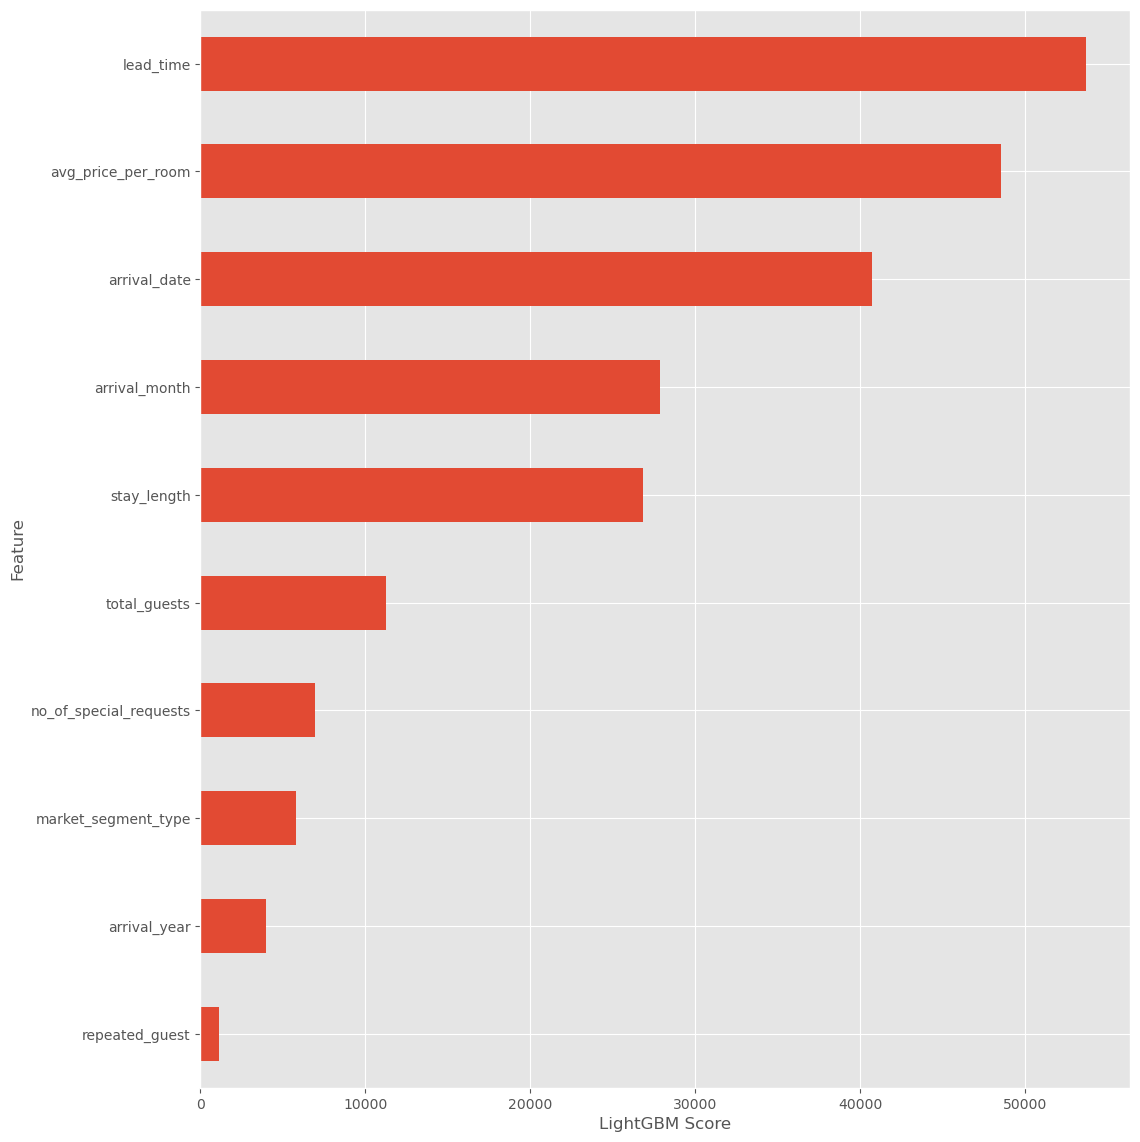

In [22]:
plt.figure(figsize = (12, 14))
pd.DataFrame(lgb_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('LightGBM Score')
plt.ylabel('Feature')
plt.show();

In [23]:
lgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

submission['booking_status'] = lgb_preds_test
submission.head()

,id,booking_status
0,42100,0.065298
1,42101,0.102220
2,42102,0.246767
3,42103,0.056673
4,42104,0.495469


In [24]:
submission.to_csv('LightGBM_10_features__optuna_submission.csv', index = False)